In [1]:
#- Scientific stack
import numpy as np
import matplotlib.pyplot as plt
from dkps.dkps import DataKernelPerspectiveSpace

#- Transformers / embedding models
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

import transformers
 
#- Utils
import gc
import torch
from tqdm import tqdm

In [2]:
#- get some toy data
n_queries=10
query_set = load_dataset("yahoo_answers_topics", split=f'train[:{n_queries}]', trust_remote_code=True)['question_title']
print(query_set[:2])

["why doesn't an optical mouse work on a glass table?", 'What is the best off-road motorcycle trail ?']


In [3]:
#- picking arbtirary foundation model.
if 'pipeline' not in locals():
    pipeline = transformers.pipeline(task='text-generation', model='meta-llama/Llama-3.1-8B-Instruct')
    pipeline.tokenizer.pad_token_id = 128009
    pipeline.tokenizer.padding_side='left'

generation_kwargs={
        'batch_size':10,
        'max_new_tokens':10,
        'eos_token_id':128009,
        'do_sample':True,
        'temperature':1,
        'num_return_sequences':5
}

message_list = [
    #- Shortening queries arbitrarily to make faster
    [{"role": "user", "content": q[:20]}] for q in query_set 
]

n_models = 5
output_dict = {}
for i in range(n_models):
    output_dict[i] = pipeline(message_list, **generation_kwargs)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [4]:
if 'embedding_model' not in locals():
    embedding_model = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True)


response_dict = {}
embedding_dict = {}
for i in range(n_models):
    response_dict[i] = []
    embedding_dict[i] = []

    for j in range(n_queries):
        response_dict[i].append([o['generated_text'][-1]['content'] for o in output_dict[i][j]])
        embedding_dict[i].append(embedding_model.encode(response_dict[i][j]))
        
    embedding_dict[i] = np.array(embedding_dict[i])

<All keys matched successfully>


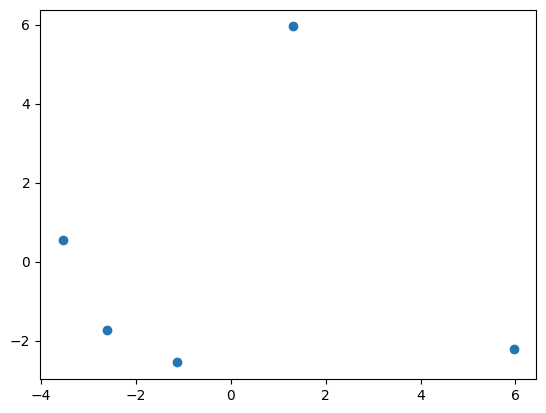

In [5]:
DKPS = DataKernelPerspectiveSpace(np.mean, 1, 'euclidean', None, 2)
dkps = DKPS.fit_transform(embedding_dict)

plt.scatter(dkps[:, 0], dkps[:,1])